<a href="https://colab.research.google.com/github/quent1fvr/Infection_pulmonaire/blob/Reda/Infection_pulmonaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I - Importation des données

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import keras
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/UV PROJET P6/COVID_dataset.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/tmp') # Extracts the files into the /tmp folder
zip_ref.close()

# II - Etude de la distribution des données "brutes"

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#--------------------------------- Visualisation des données --------------------------------- 

def visualisation(infoGen, infoHisto, infoMoy):
  
    tab_normal = []
    tab_malade = []
    nb_total_img = 0
    path_normal = '/tmp/COVID_crop/normal'
    path_malade = '/tmp/COVID_crop/malade'

    for base in os.walk(path_normal):
        #print('folder "', base[0], '" containing ', len(base[2]), ' files')
        tab_normal.append(len(base[2]))
        nb_total_img += len(base[2])
    tab_normal.pop(0)
    tab_normal.sort()
    #print(tab_normal)
    for base in os.walk(path_malade):
        #print('folder "', base[0], '" containing ', len(base[2]), ' files')
        tab_malade.append(len(base[2]))
        nb_total_img += len(base[2])
    tab_malade.pop(0)
    tab_malade.sort()
    #print(tab_malade)

    #---------- infos générales ----------
    if infoGen == True:
      print("---------- infos générales ----------\n")
      print("Nombre de scans de personnes normales :", len(os.listdir('/tmp/COVID_crop/normal')))
      print("Nombre de scans de personnes malades :", len(os.listdir('/tmp/COVID_crop/malade')))
      print("Nombre d'images :", nb_total_img)
      x = np.array([len(os.listdir(path_normal)), len(os.listdir(path_malade))])
      labels = ['normal', 'malade']
      colors = {'normal': 'chartreuse','malade': 'teal' }
      plt.pie(x, labels=labels, autopct='%.0f%%', radius=1.5, colors=[colors[key] for key in labels], textprops={'fontsize': 18})
      plt.show()

    #---------- histogrammes ----------
    if infoHisto == True:
      print("\n---------- histogrammes ----------\n")
      plt.figure(figsize=(10, 10))
      x0 = tab_normal
      x1 = tab_malade
      bins = max(len(x0), len(x1))
      plt.hist(x0, bins, alpha=0.8, label="Distribution du nombre d'images par scan normal")
      plt.hist(x1, bins, alpha=0.8, label="Distribution du nombre d'images par scan malade")
      plt.legend(loc='lower right')
      plt.xlabel("Nombres d'images par scan")
      plt.ylabel("Occurences")
      plt.show()

    #---------- infos sur les moyennes ----------
    if infoMoy == True:
      print("\n---------- infos sur les moyennes ----------\n")
      x0_mean = np.mean(tab_normal)
      x1_mean = np.mean(tab_malade)
      avg = (59*x0_mean + 41*x1_mean)/100
      print("Moyenne d'images pour les scans de personnes normales :", x0_mean)
      print("Moyenne d'images pour les scans de personnes malades :", x1_mean)
      print("Moyenne d'images pour tous les scans confondus :", avg)

In [ ]:
visualisation(True, True, True)

# III - Padding des données

### 1. On élimine les scans contenant moins de 40 et plus de 100 images


In [199]:
import shutil
num_skipped = 0
for folder_name in ("normal", "malade"):
    folder_path = os.path.join("/tmp/COVID_crop", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if len(os.listdir(fpath)) > 100 or len(os.listdir(fpath)) < 40:
            num_skipped += 1
            shutil.rmtree(fpath)

print("Deleted %d scans" % num_skipped)

Deleted 1016 scans


---------- infos générales ----------

Nombre de scans de personnes normales : 814
Nombre de scans de personnes malades : 792
Nombre d'images : 121605


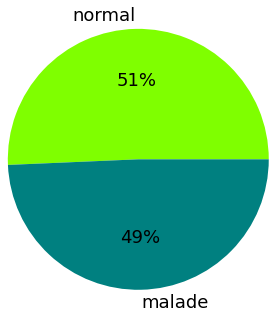


---------- histogrammes ----------



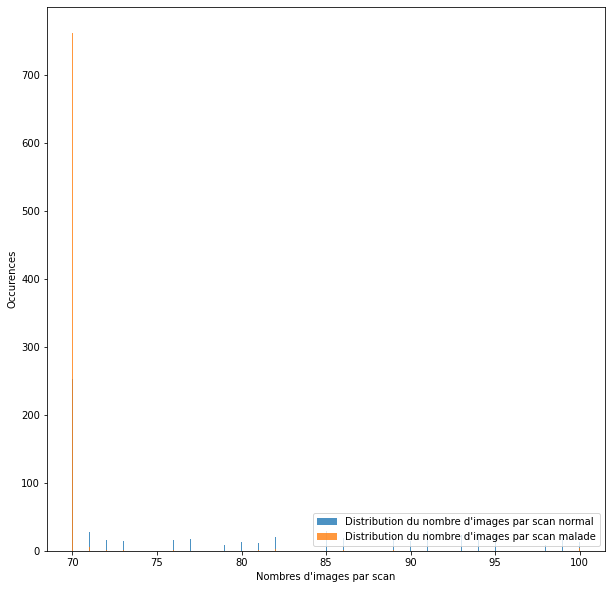


---------- infos sur les moyennes ----------

Moyenne d'images pour les scan de personnes normales : 80.83046683046683
Moyenne d'images pour les scan de personnes malades : 70.4659090909091
Moyenne d'images pour tous les scans confondus : 76.58099815724816


In [200]:
visualisation(True, True, True)

### 2. On comble les scans contenant moins de 70 images (Choix à faire)

#### 2.1. Méthode 1 : Comble par ajout d'images noires 

In [179]:
num_skipped = 0
from PIL import Image
for folder_name in ("normal", "malade"):
    folder_path = os.path.join("/tmp/COVID_crop", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if len(os.listdir(fpath)) < 70:
            for i in range (70 - len(os.listdir(fpath))) : 
                new_im = Image.new('RGB', (128, 128), (0, 0, 0))
                new_im.save(fpath + "/Dark_image" + str(i), "PNG")

In [ ]:
visualisation(True, False, True)

#### 2.2. Méthode 2 : Comble par copie d'images "intéressantes"


In [181]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
import shutil

def pathImg(index_img):
  if index_img < 10:
    return fpath + "/000" + str(index_img) + ".png"
  else:
    return fpath + "/00" + str(index_img) + ".png"

for folder_name in ("normal", "malade"):
    folder_path = os.path.join("/tmp/COVID_crop", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if len(os.listdir(fpath)) < 70:
            ''' choix index première image à copier
            méthode1 : choix de l'index à la moyenne inférieur du scan
            '''
            index_img1 = len(os.listdir(fpath))//2
            path_img1 = pathImg(index_img1)
            path_img2 = path_img1[:-2] + str(int(path_img1[len(path_img1)-2:]) + 2)
            shutil.copyfile(path_img1, path_img2)
            
            compteur_img_toAdd = 70 - len(os.listdir(fpath))

            while compteur_img_toAdd != 0:
                
                index_img1 += 2
                path_img1 = pathImg(index_img1)
                path_img2 = path_img1[:-2] + str(int(path_img1[len(path_img1)-2:]) + 2)
                shutil.copyfile(path_img1, path_img2)
                compteur_img_toAdd -= 1


In [ ]:
visualisation(True, False, True)

### 3. On élimine des images dans les scans contenant plus de 70 images (Choix à faire)

#### 3.1. Méthode 1 : Elimination aléatoire

In [ ]:
import shutil
for folder_name in ("normal", "malade"):
    folder_path = os.path.join("/tmp/COVID_crop", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if len(os.listdir(fpath)) > 70:
            for i in range(len(os.listdir(fpath)) - 70):
                # suppression des images numérotées entre 0010 et 0010 < nb_random < nb_images_dans_scan
                delete_path = fpath + "/00" + str(np.random.randint(10, len(os.listdir(fpath)))) + ".png"
                while os.path.exists(delete_path):
                    os.remove(delete_path)

In [ ]:
visualisation(True, False, True)

#### 3.2. Méthode 2 : Elimination par comparaison MSE & SSIM

##### Test

SSIM(Score of similarity): 0.6683536764047817

Image 1 :



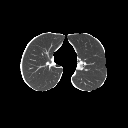


Image 2 :



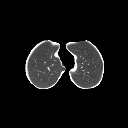


Différence :



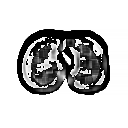

In [204]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2

path_image1 = "/tmp/COVID_crop/normal/1/0022.png"
path_image2 = "/tmp/COVID_crop/normal/1/0015.png"

# load the two input images
imageA = cv2.imread(path_image1)
imageB = cv2.imread(path_image2)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(imageA, imageB, full=True, multichannel=True)
diff = (diff * 255).astype("uint8")
print("SSIM(Score of similarity): {}".format(score))

from google.colab.patches import cv2_imshow
# show the output images
print("\nImage 1 :\n")
cv2_imshow(imageA)
print("\nImage 2 :\n")
cv2_imshow(imageB)
print("\nDifférence :\n")
cv2_imshow(diff)

The ***score*** represents the structural similarity index between the two input images. This value can fall into the range [-1, 1] with a value of one being a “perfect match”.

The ***diff*** image contains the actual image differences between the two input images that we wish to visualize. The difference image is currently represented as a floating point data type in the range [0, 1] so we first convert the array to 8-bit unsigned integers in the range [0, 255] (Line 26) before we can further process it using OpenCV.

#### Methode

In [ ]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
import shutil

def pathImg(index_img):
    if index_img < 10:
        return fpath + "/000" + str(index_img) + ".png"
    else:
        return fpath + "/00" + str(index_img) + ".png"

for folder_name in ("normal", "malade"):
    folder_path = os.path.join("/tmp/COVID_crop", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if len(os.listdir(fpath)) > 70:
            compteur_img_toDel = len(os.listdir(fpath)) - 70
            while compteur_img_toDel != 0:

                # ---------- choix des images à comparer ----------
                ''' choix index image1
                sachant que les images sont numérotées entre 0001 et 0***
                méthode : choix random de l'index
                '''
                index_img1 = np.random.randint(1, len(os.listdir(fpath)) - 1)
                while os.path.exists(pathImg(index_img1)) == False:
                  index_img1 = np.random.randint(1, len(os.listdir(fpath)) - 1)
                else:
                  path_img1 = pathImg(index_img1)
                ''' choix index image2
                sachant qu'elle doit être la plus proche voisine de l'image1
                méthode : recherche de l'index le plus proche supérieur
                '''
                index_img2 = index_img1 + 1                
                while os.path.exists(pathImg(index_img2)) == False:
                  index_img2 += 1
                else:
                  path_img2 = pathImg(index_img2)

                # ------------- comparaison des 2 images successives -------------
                image1 = cv2.imread(path_img1)
                image2 = cv2.imread(path_img2)
                #print("\nImage1\nPath : ", path_img1, "\nShape : ", image1.shape)
                #print("Image2\nPath : ", path_img2, "\nShape : ", image2.shape, "\n")
                (score, diff) = compare_ssim(image1, image2, full=True, multichannel=True)
                diff = (diff * 255).astype("uint8")
                #print(fpath, compteur_img_toDel, "SSIM: {}".format(score))

                # ---------- suppression de l'image1 ----------
                # critère : SSIM > 0.80 (images très similaires)
                if score > 0.80 and compteur_img_toDel != 0 :
                    compteur_img_toDel -= 1
                    while os.path.exists(path_img1):
                        os.remove(path_img1)

In [ ]:
visualisation(True, False, True)

Attention méthode SSIM moyen car des images toutes noires sont plus similaires à d'autres "moyenne" que deux "moyennes" entre elles...

# IV - Etude de la distribution des données "normalisées"

In [ ]:
# faire un truc du type, en créant des fonctions pour chaque type de padding des données dans la partie précédente
'''padding(ecremageGrossier, remplissageScansMethode1, epurationScansMethode1)'''

In [ ]:
visualisation(True, True, True)

# V - Phase d'entrainement du modèle

